<a href="https://colab.research.google.com/github/EvaTartaruga/TensorFlow/blob/master/class/CNN/cat_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It is highly recommended to use a powerful **GPU**, you can use it for free uploading this notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
<table align="center">
 <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ezponda/intro_deep_learning/blob/main/class/CNN/cat_vs_dogs.ipynb">
        <img src="https://colab.research.google.com/img/colab_favicon_256px.png"  width="50" height="50" style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/ezponda/intro_deep_learning/blob/main/class/CNN/cat_vs_dogs.ipynb">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png"  width="50" height="50" style="padding-bottom:5px;" />View Source on GitHub</a></td>
</table>

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
tf.random.set_seed(0)

# Introduction to Tensorflow  Dataset
[Tensorflow tf.data.Dataset tutorial](https://www.tensorflow.org/guide/data)

TensorFlow's tf.data API, which provides a convenient way to create efficient input pipelines for training and evaluation of machine learning models. `tf.data.Dataset` is an abstraction of a
sequence of elements.

The first step to using the tf.data API is creating a Dataset object. Datasets can be created from various sources, including in-memory data, files, or by generating data on-the-fly.

For this example, let's create a dataset from an in-memory NumPy array.

In [2]:
# Create a sample NumPy array
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Create a tf.data Dataset from the NumPy array
dataset = tf.data.Dataset.from_tensor_slices(data)

The `Dataset` object is a Python iterable. This makes it possible to consume its
elements using a for loop:

In [3]:
for elem in dataset:
      print(elem.numpy())

1
2
3
4
5
6
7
8
9
10


Now that we have a dataset, we can apply various transformations to prepare the data for training. Some common transformations include shuffling, batching, and repeating.

**Shuffle**

Randomly shuffles the elements of this dataset.

This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

In [4]:
buffer_size = 2

dataset = dataset.shuffle(buffer_size)

for elem in dataset:
      print(elem.numpy())

2
1
4
3
6
5
7
9
10
8


**Batch**

Combines consecutive elements of this dataset into batches.

In [5]:
batch_size = 2

dataset = dataset.batch(batch_size)

for elem in dataset:
      print(elem.numpy())

[1 3]
[4 5]
[6 2]
[8 7]
[10  9]


In addition to using in-memory data, the `tf.data` API can also read data from files, such as images or text files. For example, let's create a dataset of text lines from a sample file.

In [6]:
# Create a sample text file
with open("sample.txt", "w") as f:
    f.write("This is a sample text file.\n")
    f.write("Each line represents an element in the dataset.\n")
    f.write("We can apply various transformations to the data.\n")
    f.write("This makes it easy to prepare data for training.\n")

# Create a tf.data Dataset from the text file
dataset = tf.data.TextLineDataset("sample.txt")
for elem in dataset:
      print(elem.numpy())

b'This is a sample text file.'
b'Each line represents an element in the dataset.'
b'We can apply various transformations to the data.'
b'This makes it easy to prepare data for training.'


To preprocess the text data, we can apply a map function to the dataset. This allows us to perform arbitrary operations on each element.

In [7]:
# Define a preprocessing function
def preprocess_text(line):
    line = tf.strings.lower(line)
    line = tf.strings.strip(line)
    return line

# Apply the preprocessing function to the dataset
dataset = dataset.map(preprocess_text)

for elem in dataset:
      print(elem.numpy())

b'this is a sample text file.'
b'each line represents an element in the dataset.'
b'we can apply various transformations to the data.'
b'this makes it easy to prepare data for training.'


# Cat vs dog

In [8]:
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
dataset = dataset['train']
class_names = ['cat', 'dog']

size = tf.data.experimental.cardinality(dataset).numpy()
print(f'number of images:{size}')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.KXBOTM_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
number of images:23262


We need all images to be the same size, we can use [`resize`](https://www.tensorflow.org/api_docs/python/tf/image/resize):

```python
tf.image.resize(
    images, size, method=ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)
```


In [9]:
image_size = (96, 96, 3)


def preprocess_img(images, size=(96, 96)):
    return tf.image.resize(images, size)

dataset = dataset.map(lambda images, labels: (preprocess_img(images), labels))

Split the dataset, you can use [different techniques](https://www.tensorflow.org/datasets/splits)

In [10]:
batch_size = 32
train_size = int(0.75 * size)
val_size = int(0.1 * size)

train_ds = dataset.take(train_size)
train_ds = train_ds.shuffle(1000).batch(batch_size).cache() # esto es para guardar la info en ram
remaining = dataset.skip(train_size) # omite los primeros datos ya usados en train_ds

val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

val_ds = val_ds.shuffle(1000).batch(batch_size).cache()
test_ds = test_ds.batch(batch_size).cache()

In [11]:
# prefetch() permite que la CPU prepare el siguiente batch de datos mientras la GPU está entrenando con el batch actual.
# Esto ayuda a evitar que la GPU se quede esperando a que se cargue el siguiente lote, y mejora la eficiencia.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

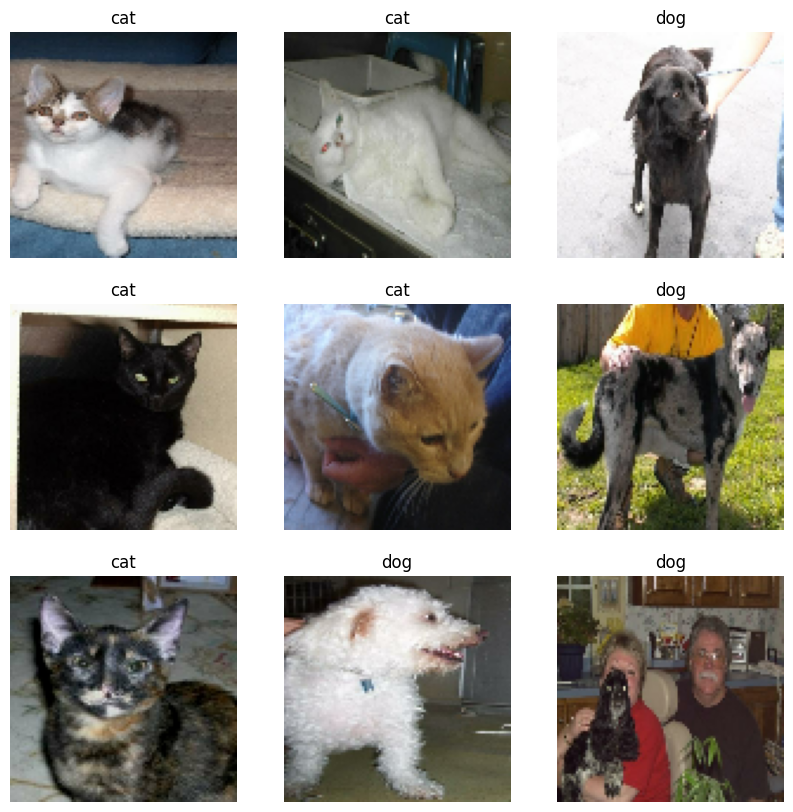

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# CNN model

You can visit the tutorial [Introduction_to_CNN](https://github.com/ezponda/intro_deep_learning/blob/main/class/CNN/Introduction_to_CNN.ipynb)

## CNN model in Keras



<img src="https://i.ibb.co/D8CmT6K/cnn.jpg" alt="cnn" border="0">



A Convolutional Neural Network (CNN) architecture has four main parts:

- A **convolutional layer** that extracts features from a source image.

- A **pooling layer** that reduces the image dimensionality without losing important features or patterns.

- A **flattening layer** that transforms a n-dimensional tensor into a vector that can be fed into a fully connected neural network.

- A **fully connected layer** also known as the dense layer.

### Rescaling

For converting the images to   \[0,1\] range.
```python
normalization_layer = layers.Rescaling(1./255)
next_layer = normalization_layer(prev_layer)
```
or simply
```python
reescaling = layers.Rescaling(1. / 255)(inputs)
```

### Convolutional layer

In the convolutional layers (`Conv2D`) we will configure the following parameters:

- **filters**: number of feature maps.
- **kernel_size**: can be either an integer or a tuple of two integers. Specifies the height and width of the kernel.
- **padding**: allows you to include padding in the input data. With 'valid' it is not applied, with 'same' it is configured so that the dimension at the output of the convolution is the same as at the input.
- **activation**: activation function implemented. Recommended ReLU.

[Link to documentation](https://keras.io/api/layers/convolution_layers/convolution2d/)

```python
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), padding='valid',
    activation=None, kernel_regularizer=None)

```

With Functional API:
```python
next_layer = layers.Conv2D(filters=8, kernel_size=3, activation='relu', name='conv_1')(prev_layer)
```

With Sequential:
```python
model.add(layers.Conv2D(filters=8,kernel_size=3, activation='relu', name='conv_1'))
```

### Pooling layer

A pooling layer is a new layer added after the convolutional layer. Specifically, after a nonlinearity ( ReLU) you can choose between [average pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) or [max pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D). Usually max pooling is the best choice.


With Functional API:
```python
conv_1 = layers.Conv2D(filters=8, kernel_size=3, activation='relu', name='conv_1')(prev_layer)

pool_1 = layers.MaxPool2D(pool_size=(2, 2), name='pool_1')(conv_1)
```

With Sequential:
```python
model.add(layers.AveragePooling2D(pool_size=(2, 2), name='pool_1'))
```

### Flattening

Prepares a vector for the fully connected layers.

With Functional API:

```python
next_layer = layers.Flatten(name='flatten')(prev_layer)
```

With Sequential:
```python
model.add(layers.Flatten(name='flatten'))
```

There is another alternative for flattening that is a type of pooling that is called global pooling. Global pooling down-samples the entire feature map to a single value.

You can also choose between [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) and [GlobalMaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).

```python
model.add(layers.GlobalMaxPool2D(name='GlobalMaxPooling2D'))
```

### Fully-connected layer

Dense layer like a simple neural network

## Question 1: Create a model with two convolutional layers without pooling and without any regularization

In [19]:
inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.Rescaling(1. / 255)(inputs)

# Conv Layer 1
conv_1 = layers.Conv2D(filters= 16, kernel_size=3, padding='valid',
                      activation='relu', name='conv_1')(reescaling)

# Conv Layer 2
conv_2 = layers.Conv2D(filters= 16, kernel_size=3, padding='valid',
                      activation='relu', name='conv_2')(conv_1)


# Fully-connected
# Flattening
flat = layers.Flatten(name='flatten')(conv_2)

# dense
dense = layers.Dense(64, activation='relu', name='dense')(flat)

#output
outputs = layers.Dense(1, activation='sigmoid', name='output')(dense)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [20]:
model_1.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [21]:
epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1)

history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,

)

Epoch 1/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.6054 - loss: 0.7520 - val_accuracy: 0.7089 - val_loss: 0.5484
Epoch 2/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7570 - loss: 0.4973 - val_accuracy: 0.7532 - val_loss: 0.5287
Epoch 3/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8532 - loss: 0.3364 - val_accuracy: 0.7403 - val_loss: 0.6763
Epoch 4/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9346 - loss: 0.1754 - val_accuracy: 0.7377 - val_loss: 0.9324
Epoch 5/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9643 - loss: 0.0985 - val_accuracy: 0.7300 - val_loss: 1.0995
Epoch 6/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9703 - loss: 0.0853 - val_accuracy: 0.7382 - val_loss: 1.1579
Epoch 7/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9886 - loss: 0.0388 - val_accuracy: 0.7193 - val_loss: 1.4771
Epoch 8/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9934 - loss: 0.0215 - val_accuracy: 

In [22]:
results = model_1.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7244 - loss: 1.6241
Test Loss: 1.5925586223602295
Test Accuracy: 0.7163323760032654


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


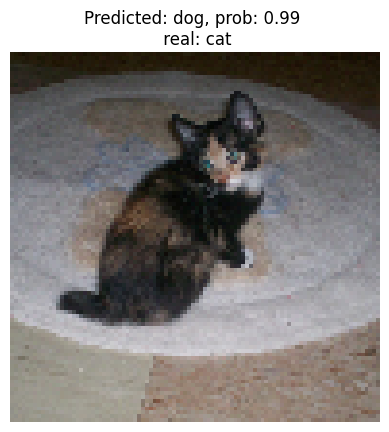

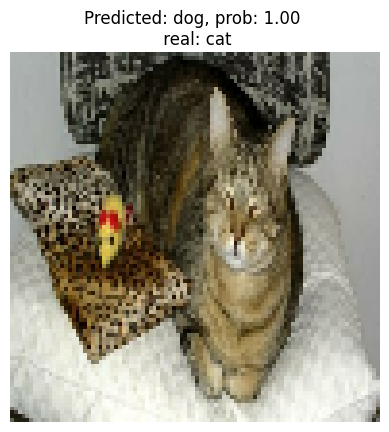

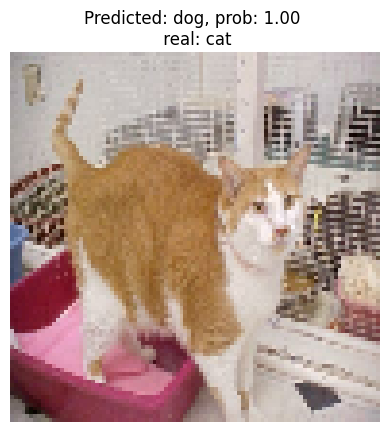

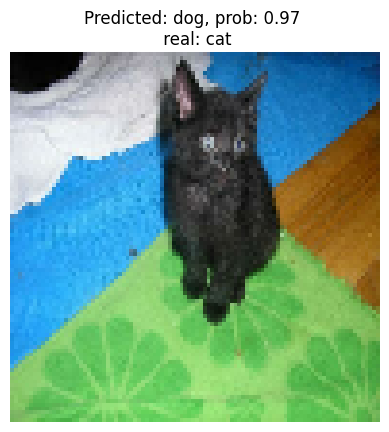

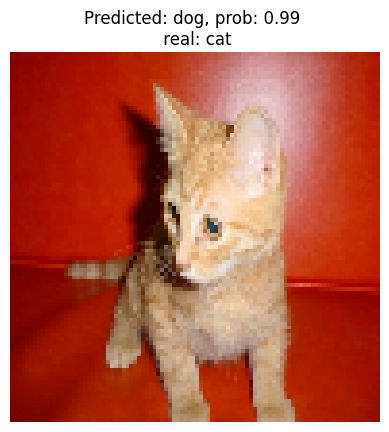

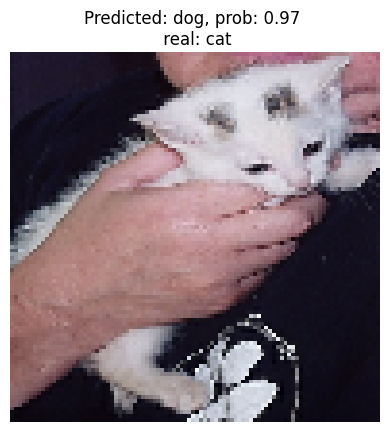

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


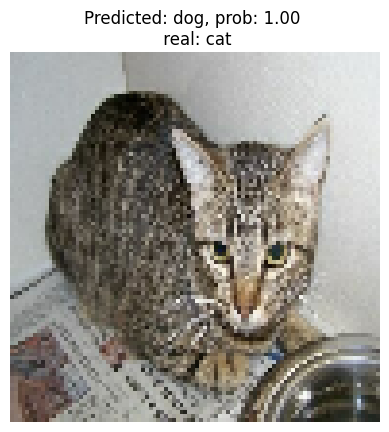

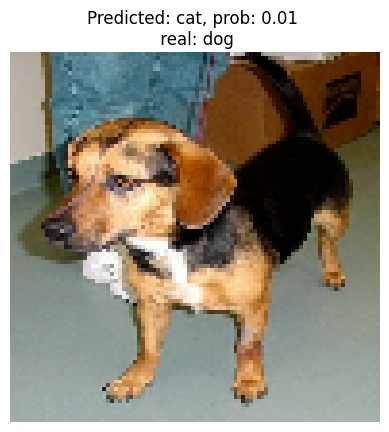

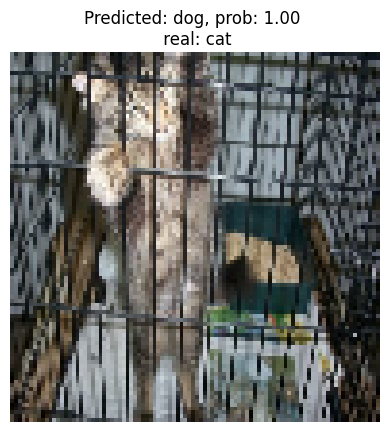

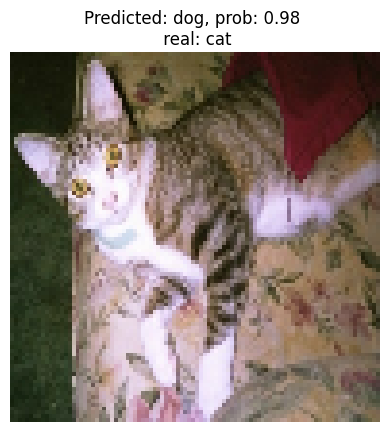

In [23]:
def show_errors(val_ds, model, class_names, n_images=10):
    n_plots = 0
    for images, labels in val_ds:
        pred_prob = model.predict(images)
        preds = (1.0 * (pred_prob >= 0.5)).astype(np.int32).flatten()
        bad_pred_inds = np.where(preds != labels)[0]
        for ind in list(bad_pred_inds):
            n_plots += 1
            real_class = class_names[labels[ind].numpy()]
            pred_class = class_names[preds[ind]]
            prob = pred_prob[ind][0]
            plt.imshow(images[ind].numpy().astype("uint8"))
            plt.title('Predicted: {0}, prob: {1:.2f} \n real: {2}'.format(
                pred_class, prob, real_class))
            plt.axis('off')
            plt.show()

            if n_plots == n_images:
                return
    return


show_errors(test_ds, model_1, class_names, n_images=10)

## Question 2: Introduce pooling to the previous model and obtain a better `test_accuracy`, Do not use any regularization

In [29]:
inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.Rescaling(1. / 255)(inputs)

# Conv Layer 1
conv_1 = layers.Conv2D(filters= 16, kernel_size=3, padding='valid',
                      activation='relu', name='conv_1')(reescaling)
pool_1 = layers.MaxPooling2D(pool_size=(2,2), name='pool_1')(conv_1)

# Conv Layer 2
conv_2 = layers.Conv2D(filters= 16, kernel_size=3, padding='valid',
                      activation='relu', name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2,2), name='pool_2')(conv_2)


# Fully-connected
# Flattening
flat = layers.Flatten(name='flatten')(pool_2)

# dense
dense = layers.Dense(64, activation='relu', name='dense')(flat)

#output
outputs = layers.Dense(1, activation='sigmoid', name='output')(dense)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [26]:
model_2.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1)

history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=es_callback
)

Epoch 1/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6089 - loss: 0.6504 - val_accuracy: 0.7068 - val_loss: 0.5703
Epoch 2/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7437 - loss: 0.5197 - val_accuracy: 0.7425 - val_loss: 0.5270
Epoch 3/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7885 - loss: 0.4521 - val_accuracy: 0.7515 - val_loss: 0.5314
Epoch 4/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8169 - loss: 0.3987 - val_accuracy: 0.7420 - val_loss: 0.6240
Epoch 4: early stopping


In [27]:
results = model_2.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7227 - loss: 0.6647
Test Loss: 0.6511025428771973
Test Accuracy: 0.7309455871582031


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


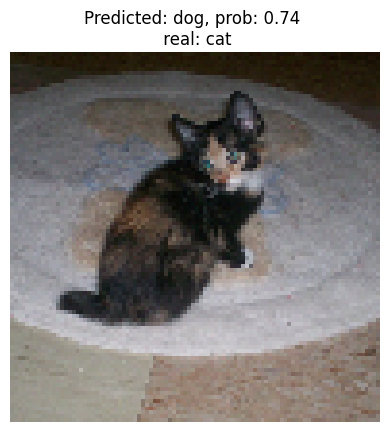

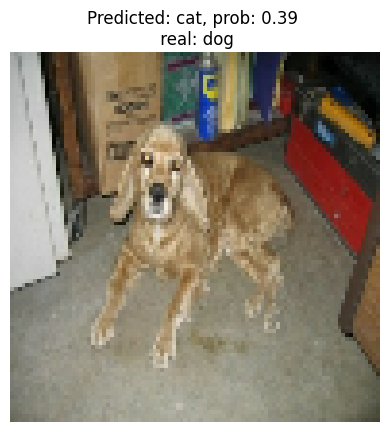

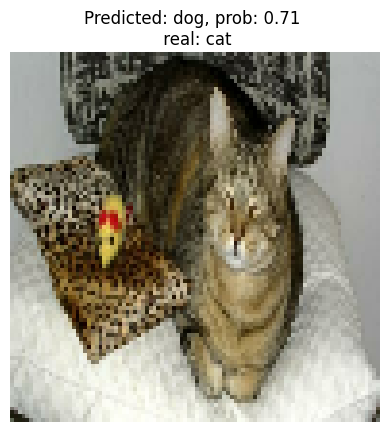

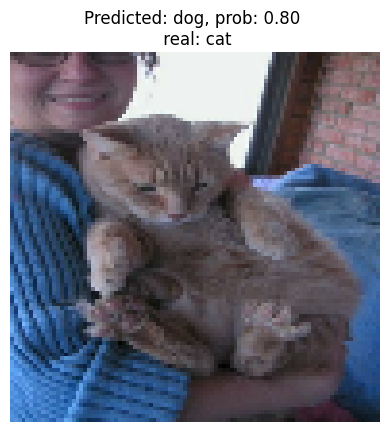

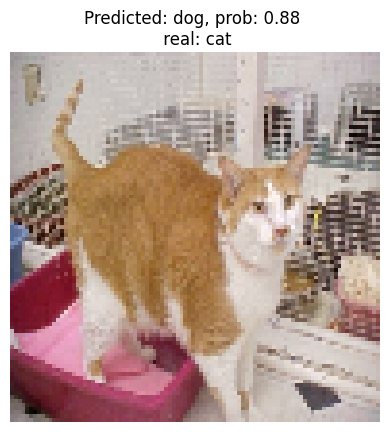

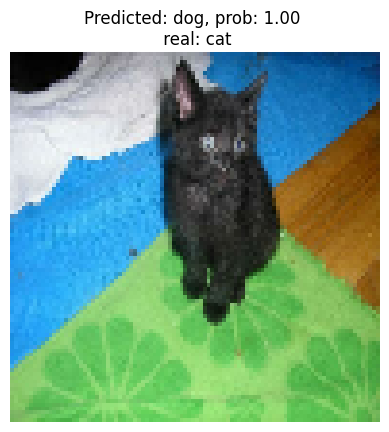

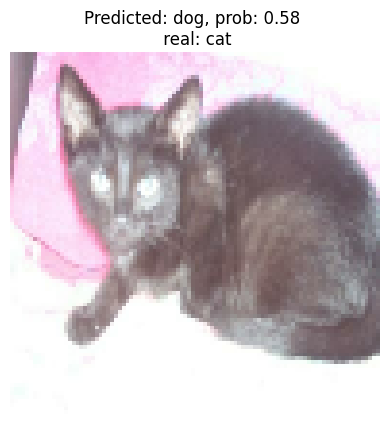

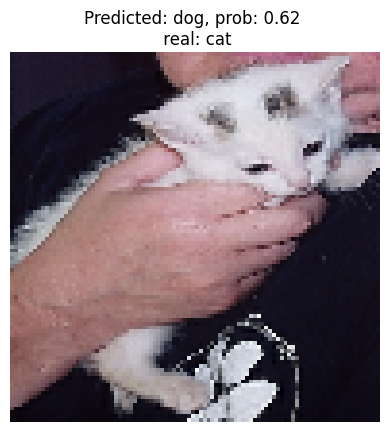

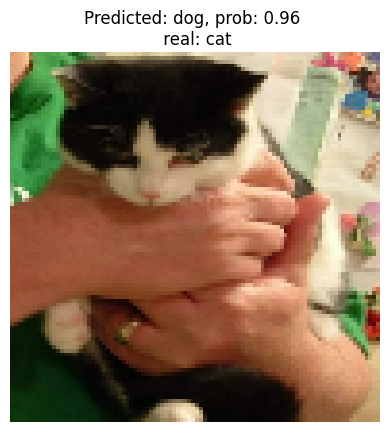

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


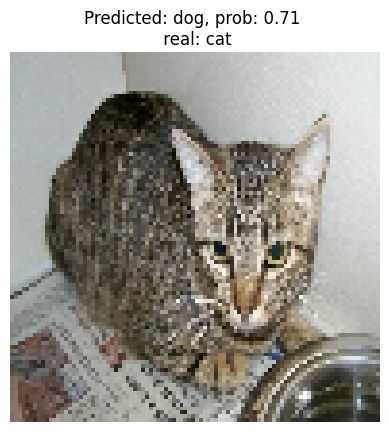

In [28]:
show_errors(test_ds, model_2, class_names, n_images=10)

## Question 3: Introduce regularization (you can try data augmentation) and increase the number of layers to obtain a better `test_accuracy`. Try to obtain `Test Accuracy > 0.82`



In [31]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip(),
    layers.RandomRotation(0.25),
  ]
)

In [57]:
inputs = tf.keras.Input(shape=image_size, name='input')
#x = data_augmentation(inputs)
reescaling = layers.Rescaling(1. / 255)(inputs)

# Conv Layer 1
conv_1 = layers.Conv2D(filters= 64, kernel_size=3, padding='same',
                      activation='relu', name='conv_1')(reescaling)
#conv_1 = layers.BatchNormalization()(conv_1)
pool_1 = layers.MaxPooling2D(pool_size=(2,2), name='pool_1')(conv_1)
pool_1 = layers.Dropout(0.3)(pool_1)

# Conv Layer 2
conv_2 = layers.Conv2D(filters= 32, kernel_size=3, padding='same',
                      activation='relu', name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2,2), name='pool_2')(conv_2)
pool_2 = layers.Dropout(0.3)(pool_2)


# Conv Layer 3
conv_3 = layers.Conv2D(filters= 16, kernel_size=3, padding='same',
                      activation='relu', name='conv_3')(pool_2)
pool_3 = layers.MaxPooling2D(pool_size=(2,2), name='pool_3')(conv_3)
pool_2 = layers.Dropout(0.3)(pool_2)


# Fully-connected
# Flattening
flat = layers.Flatten(name='flatten')(pool_3)
flat = layers.Dropout(0.3)(flat)

# dense
dense = layers.Dense(64, activation='relu', name='dense')(flat)
dense = layers.Dense(32, activation='relu', name='dense')(flat)


#output
outputs = layers.Dense(1, activation='sigmoid', name='output')(dense)

model_3 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [58]:
model_3.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1)

history = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=es_callback
)

Epoch 1/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.5420 - loss: 0.6860 - val_accuracy: 0.7102 - val_loss: 0.5795
Epoch 2/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6980 - loss: 0.5790 - val_accuracy: 0.7369 - val_loss: 0.5418
Epoch 3/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7438 - loss: 0.5183 - val_accuracy: 0.7468 - val_loss: 0.5087
Epoch 4/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7637 - loss: 0.4854 - val_accuracy: 0.7915 - val_loss: 0.4663
Epoch 5/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7877 - loss: 0.4487 - val_accuracy: 0.7975 - val_loss: 0.4359
Epoch 6/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8009 - loss: 0.4254 - val_accuracy: 0.8199 - val_loss: 0.3964
Epoch 7/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8117 - loss: 0.4058 - val_accuracy: 0.8199 - val_loss: 0.4020
Epoch 8/8
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8232 - loss: 0.3900 - val_accuracy:

In [59]:
results = model_3.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8208 - loss: 0.3877
Test Loss: 0.38338565826416016
Test Accuracy: 0.8263610601425171


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


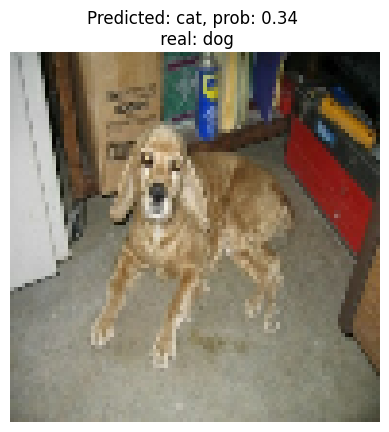

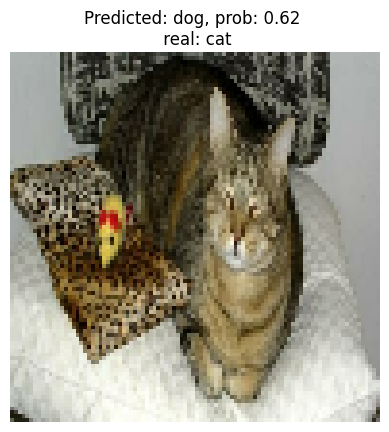

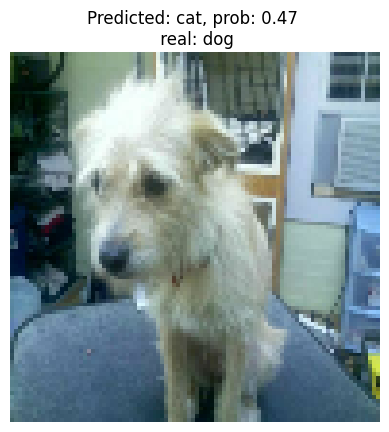

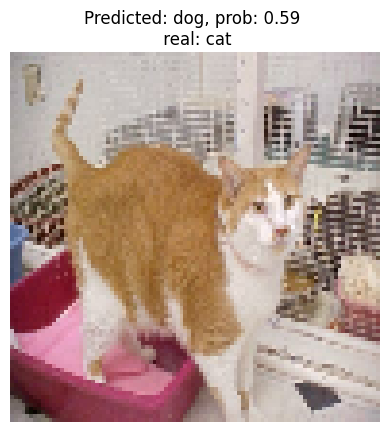

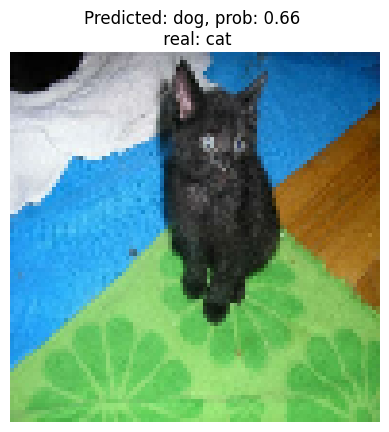

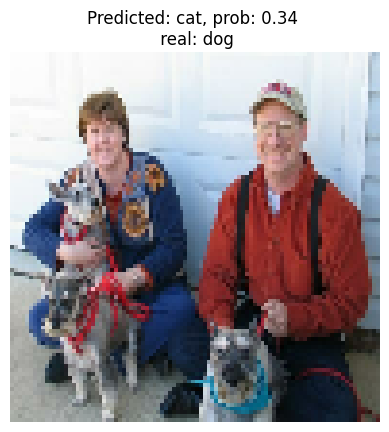

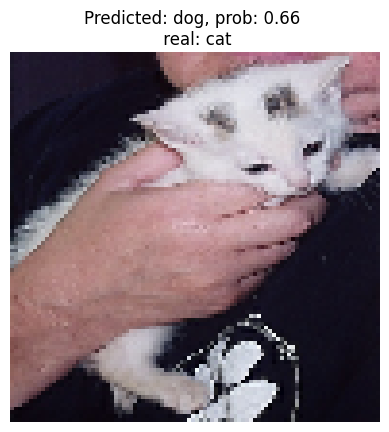

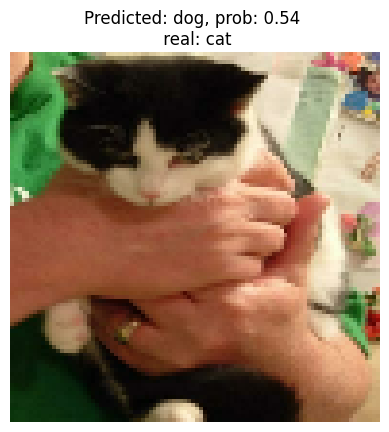

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


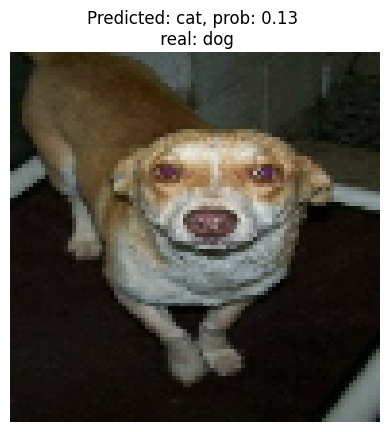

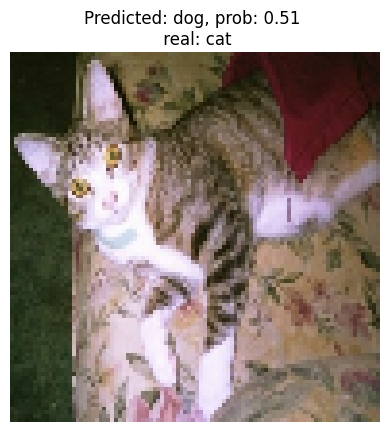

In [60]:
show_errors(test_ds, model_3, class_names, n_images=10)

## Question 3.1 (Optional): Tune a CNN Architecture with Keras Tuner

[Keras Tuner tutorial](https://github.com/ezponda/intro_deep_learning/blob/main/class/Fundamentals/Regression_tuner.ipynb) :

Hyperparameters are of two types:
1. **Model hyperparameters** like number of units, type of activation or number hidden layers.
2. **Algorithm hyperparameters** like the learning rate in adam.

The model-building function takes an argument `hp` from which you can sample hyper-parameters.

```python
def build_model(hp):
    ...
    return model

```

- `hp.Int` to sample an integer from a certain range:
```python
hp.Int('units', min_value=32, max_value=256, step=32, default=64)
```
- `hp.Float` to sample a float number from a certain range:
```python
hp.Float('dropout', min_value=0.0, max_value=0.1, default=0.005, step=0.05)
```
- `hp.Choice` to select values in a list:
```python
hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
```
- [list of hyperparameter methods](https://keras-team.github.io/keras-tuner/documentation/hyperparameters/)

In [ ]:
# !pip install -U keras-tuner

In [ ]:
import kerastuner as kt

In [ ]:
def build_cnn_model(hp):
    """Build a CNN model with tunable architecture and dropout regularization using Functional API."""
    inputs = keras.Input(shape=image_size)

    # Start the model flow with the inputs
    x = layers.Rescaling(1. / 255)(inputs)

    # Tune the number of convolutional blocks (try 1-3 blocks)
    for i in range(hp.Int('num_conv_blocks', min_value=1, max_value=3)):
        # Tune the number of filters in each Conv2D layer
        x = layers.Conv2D(
            filters=hp.Int(f'filters_{i}', min_value=16, max_value=128, step=16),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu',
            padding='same'
        )(x)

        # Add dropout after the Conv2D layer
        x = layers.Dropout(
            hp.Float(f'conv_dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        )(x)

        # Add pooling layer
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten layer before dense layers
    x = layers.Flatten()(x)

    x = layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    )(x)

    x = layers.Dropout(
        hp.Float('dense_dropout', min_value=0.0, max_value=0.5, step=0.1)
    )(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
tuner = kt.RandomSearch(build_cnn_model,
                     objective='val_loss',
                     max_trials=2,
                     directory='my_dir',
                     project_name='intro_to_kt')

# Early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Start the search
tuner.search(
    train_ds,  # Use your TensorFlow dataset
    validation_data=val_ds,
    epochs=10,
    callbacks=[es_callback]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Print the optimal architecture
print(f"Best number of convolutional blocks: {best_hps.get('num_conv_blocks')}")
for i in range(best_hps.get('num_conv_blocks')):
    print(f"Conv block {i+1}:")
    print(f"  - Filters: {best_hps.get(f'filters_{i}')}")
    print(f"  - Kernel size: {best_hps.get(f'kernel_size_{i}')}")
    print(f"  - Dropout rate: {best_hps.get(f'conv_dropout_{i}')}")

print(f"Dense layer units: {best_hps.get('dense_units')}")
print(f"Dense layer dropout: {best_hps.get('dense_dropout')}")

In [ ]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

In [ ]:

# Train the model
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[es_callback]
)

# Evaluate on test dataset
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

## Question 4: Try transfer learning

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size,
                                                     include_top=False)
pretrained_model.trainable = ...

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
inputs = tf.keras.Input(shape=image_size, name='input')

# pre-trained model
... = preprocess_input(...)
... = pretrained_model(..)

# classifier
flat = tf.keras.layers.Flatten()(...)
outputs = ...

model_tl = tf.keras.Model(inputs, outputs)
model_tl.summary()

In [ ]:
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 2

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    verbose=1)

history = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=...
)

In [ ]:
results = model_tl.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

In [ ]:
show_errors(test_ds, model_tl, class_names, n_images=10)

# Generalization

In [ ]:
def read_image(image_path, target_size=None):
    image = tf.keras.preprocessing.image.load_img(image_path,
                target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.astype(np.uint8)
    return image

def predict_plot(image_path, model, class_names, image_size):
    image = read_image(image_path, image_size[:2])
    prob = model.predict(np.expand_dims(image, 0))[0][0]
    pred_class = class_names[(1.0 * (prob >= 0.5)).astype(np.int32)]
    plt.imshow(image)
    plt.title(
        'Predicted: {0}, prob: {1:.2f}'
        .format(pred_class, prob))
    plt.axis('off')
    plt.show()

In [ ]:
url = 'https://assets.sainsburys-groceries.co.uk/gol/6754229/1/640x640.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_1.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)

In [ ]:
url = 'https://i.ytimg.com/vi/3dcli9i_pvA/hqdefault.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_2.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)

In [ ]:
url = 'https://thumbs.dreamstime.com/b/halloween-ghost-portrait-funny-dog-black-background-adorable-pup-muzle-153863580.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_3.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)